In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# Disable GPUs        
set_gpu(idxs=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In the previous notebook we have hardcoded many parts of the network. Together with the notebook we provide couple of scripts that will enable you to experiment with DQN achitecture in a more flexible way. You will need this flexibility for applying this algorithm in a more challenging environment.

## DQN

In [19]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

EXPERIMENT_FOLDER = join('Experiments', 'lunar_lander_dqn')
video_folder = join(EXPERIMENT_FOLDER, 'video')
save_interval = 100

env = gym.make('LunarLander-v2')

from gym.wrappers import monitor
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.99,
    use_cnn=False,
    mlp_n_hidden=(64, 64),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(128, ),
    mlp_value_act_f="tanh")

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-4,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)


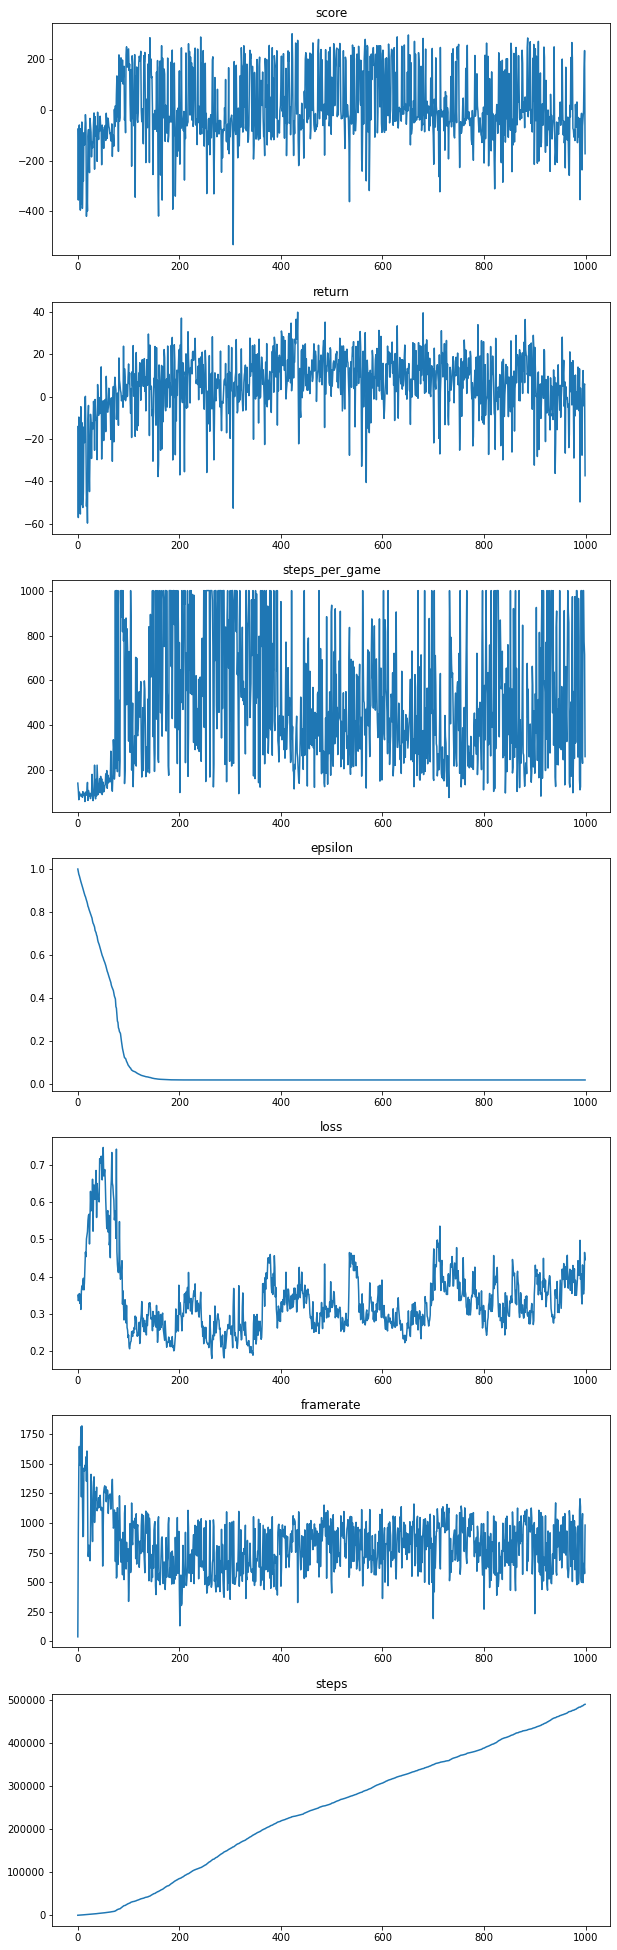

In [20]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=1000, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

In [5]:
import os
from gym import wrappers
from IPython.display import Video

from QLearning.dqn import run_episode

video_path = join(EXPERIMENT_FOLDER, 'video')

eval_env = wrappers.Monitor(env, video_path, force=True)

print(run_episode(eval_env, agent))

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name), embed=True)

INFO:tensorflow:Assets written to: Experiments\lunar_lander_dqn\run1000\assets
{'score': 274.4892804139078, 'steps_per_game': 300, 'framerate': 45.7102964487071, 'runs': 1000, 'return': 23.651678807545135, 'epsilon': 0.02, 'loss': 0.30335006, 'steps': 456015}


In [22]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

# Save history file
from QLearning.dqn import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: Experiments\lunar_lander_dqn\latest\assets


## Double DQN

In [7]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

EXPERIMENT_FOLDER = join('Experiments', 'lunar_lander_double_dqn')
video_folder = join(EXPERIMENT_FOLDER, 'video')
save_interval = 100

env = gym.make('LunarLander-v2')

from gym.wrappers import monitor
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DoubleDQN(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.99,
    use_cnn=False,
    mlp_n_hidden=(64, 64),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(128, ),
    mlp_value_act_f="tanh",
    target_network_update_freq=500,)
    
agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-4,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)


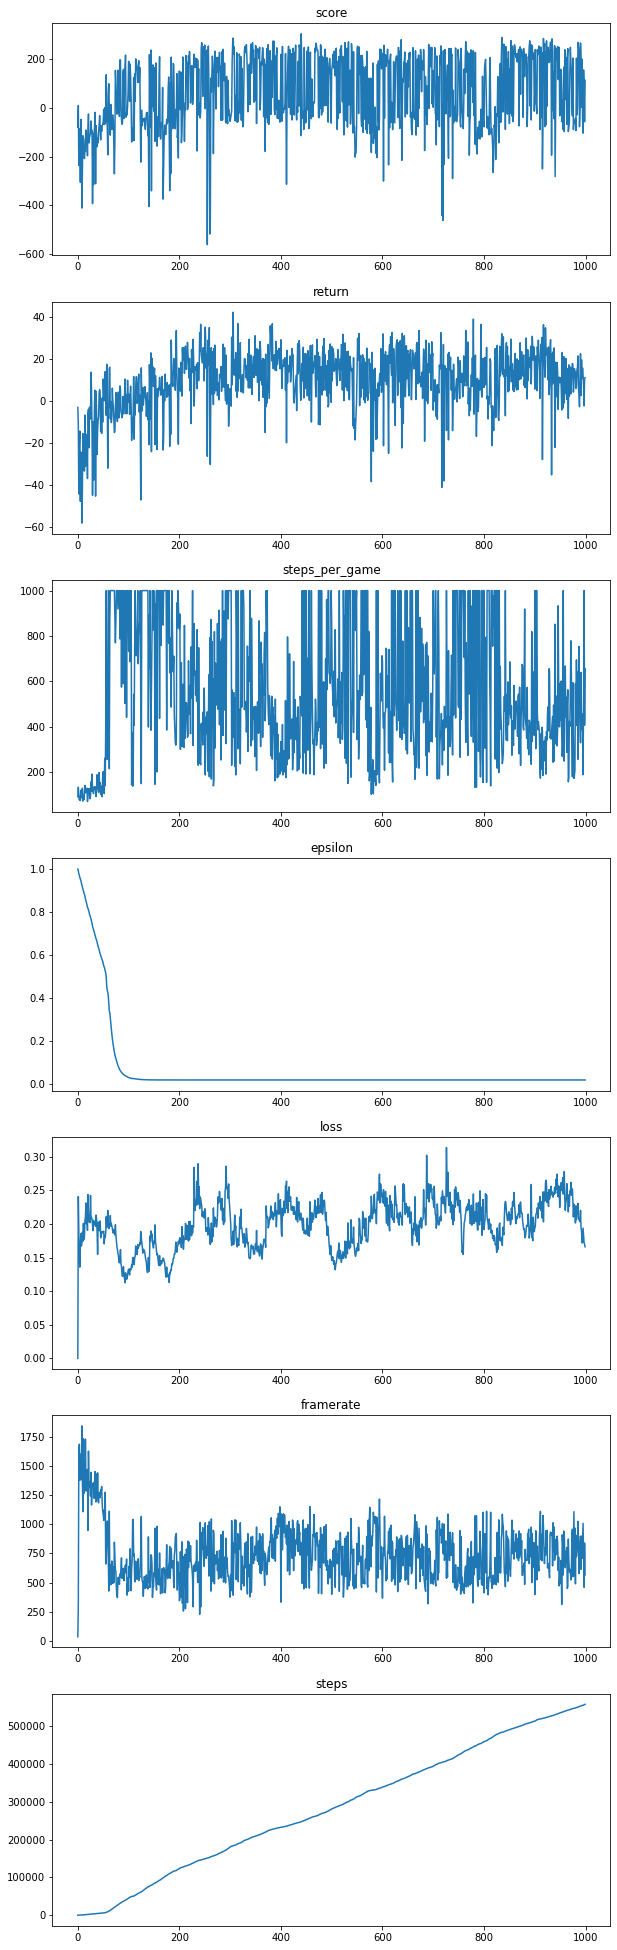

In [8]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=1000, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

In [9]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

# Save history file
from QLearning.dqn.run import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: Experiments\lunar_lander_double_dqn\latest\assets


### To load the agent and play the game
- Set the experiment folder to the ```EXPERIMENT_FOLDER``` variable
- Create the environment
- Create a instance of a network.
- Load the weights with ```q_network.load(path)```
- Create an agent ```EpsilonGreedyAgent(network=q_network)```
- Remember to set ``````EpsilonGreedyAgent(start_epsilon=0.02)`````` to a small value, to ensure exploration.

In [10]:
from os.path import join

import gym

from QLearning.dqn import EpsilonGreedyAgent, DeepQNetwork

EXPERIMENT_FOLDER = join('Experiments', 'lunar_lander_double_dqn')

env = gym.make('LunarLander-v2')
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                        use_cnn=False)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

In [12]:
import os
from gym import wrappers
from IPython.display import Video

from QLearning.dqn.run import run_episode

eval_env = wrappers.Monitor(env, video_folder, force=True)

print(run_episode(eval_env, agent, train=False))

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_folder) if '.mp4' in x][-1]
Video(os.path.join(video_folder, video_name), embed=True)

{'score': 217.68130979658392, 'steps_per_game': 483, 'framerate': 51.86485003059262, 'runs': 1, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [15]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

from QLearning.dqn import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: Experiments\lunar_lander_double_dqn\latest\assets


dict_keys(['score', 'steps_per_game', 'framerate', 'runs', 'return', 'epsilon', 'loss', 'steps', 'total_steps', 'total_episodes'])


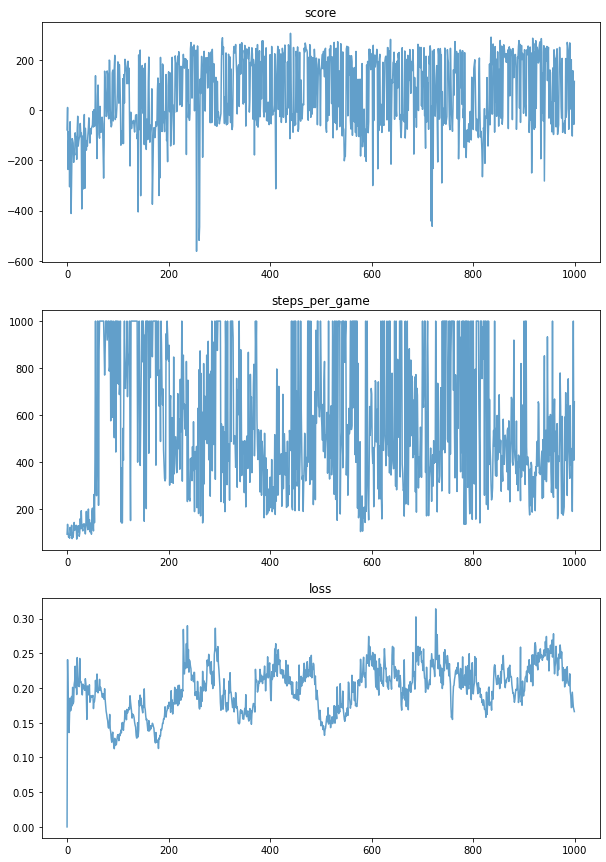

In [17]:
from QLearning.dqn.run import load_history, plot_history
import matplotlib.pyplot as plt

from os.path import join

history = load_history(join(EXPERIMENT_FOLDER, 'history.json'))
print(history.keys())
plot_history(history, ['score', 'steps_per_game', 'loss'])

You can also plot several histories alongside each other. Just pass a list of histories and names.

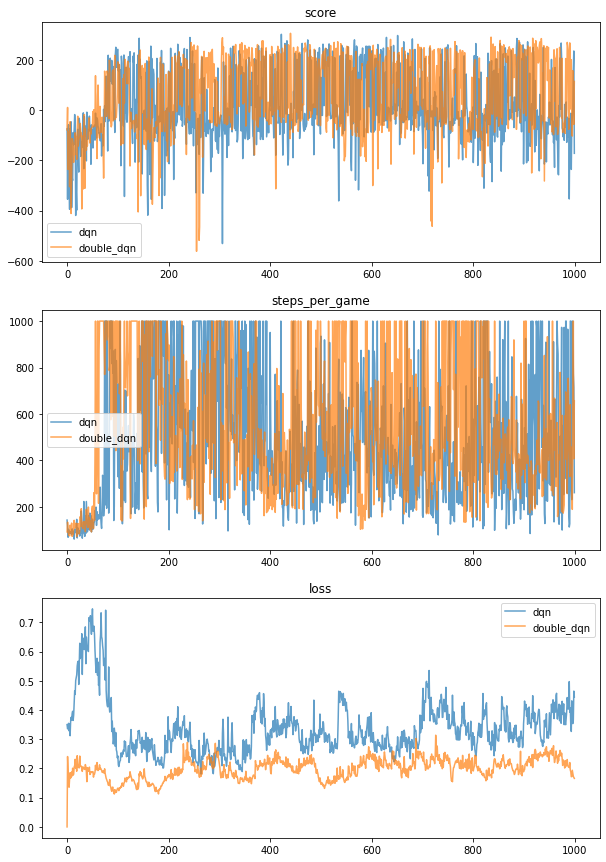

In [23]:
elems = ['score', 'steps_per_game', 'loss']

history_dqn = load_history(join('Experiments', 'lunar_lander_dqn', 'history.json'))
history_ddqn = load_history(join('Experiments', 'lunar_lander_double_dqn', 'history.json'))



plot_history([history_dqn, history_ddqn], elems, names=['dqn', 'double_dqn'])

## Excercise
Other networks are available with `from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent`. Try different environments, configurations and extensions.
Try changing:
- `update_target_network_freq`
- `learning_rate`
- number of layers, neurons
- activation function
- weight initialization
- regularization terms

What is the effect on the learning process?